In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import struct
import numpy as np
import os

def read_file(folder_name: str) -> dict:
    """
    此函数从文件夹下读取所有形如idxn-ubyte的数据文件.
    :param folder_name: 文件夹字符串名.
    :return: 包含所有以文件名（不含后缀名）为key，ndarray为value的字典.
    """
    # 检查输入的文件夹是否存在，是否可读
    if not os.path.exists(folder_name):
        raise FileNotFoundError(f"Folder doesn't exists: {folder_name}")
    if not os.access(folder_name, os.R_OK):
        raise PermissionError(f"Folder not readable: {folder_name}")

    return_dict = {}
    for elements in os.scandir(folder_name):
        if elements.is_file():
            with open(elements.path, 'rb') as file:
                magic, size = struct.unpack('>II', file.read(8))
                dimension = magic & 0xFF  # 使用位运算获取存储数据的维数
                lengths = (size,) + struct.unpack(f">{dimension - 1}I",
                                                  file.read((dimension - 1) * 4))  #定义期望得到的ndarray结构
                data_temp = np.fromfile(file, dtype=np.uint8).reshape(lengths)  # 读取二进制文件并重整成正确的结构
                return_dict[os.path.splitext(elements.name)[0]] = data_temp
    return return_dict


# 读取数据
files = read_file('./dataset')

In [3]:
import lyutorch as lyu
from sklearn.metrics import accuracy_score
img_train = lyu.tensor(files['train-images'] * 2 / 255 - 1, dtype=np.float32)
img_test = lyu.tensor(files['t10k-images'] * 2 / 255 - 1, dtype=np.float32)
label_train = lyu.tensor(files['train-labels'], dtype=np.int8)
label_test = lyu.tensor(files['t10k-labels'], dtype=np.int8)

# 将数据变成 one-hot 编码
one_hot_matrix = np.eye(10)
label_train = lyu.tensor(one_hot_matrix[label_train.flatten()].reshape(-1,10).squeeze())
label_test = lyu.tensor(one_hot_matrix[label_test.flatten()].reshape(-1,10).squeeze())

print(label_train.shape)

(60000, 10)


In [4]:
import lyutorch.nn as nn


class Net(nn.Module):
    def __init__(self, hidden_layer_size: int = 64):
        super(Net, self).__init__()
        self._hidden = hidden_layer_size
        self.fc1 = lyu.tensor(np.random.normal(size=(28 * 28, hidden_layer_size)), requires_grad=True)
        self.fc2 = lyu.tensor(np.random.normal(size=(hidden_layer_size, 10)), requires_grad=True)
        self.bias1 = lyu.tensor(np.random.normal(size=(1, hidden_layer_size)), requires_grad=True)
        self.bias2 = lyu.tensor(np.random.normal(size=(1, 10)), requires_grad=True)
        self.add_parameter('fc1', self.fc1)
        self.add_parameter('fc2', self.fc2)
        self.add_parameter('bias1', self.bias1)
        self.add_parameter('bias2', self.bias2)
        self.target = lyu.tensor(np.eye(10))

    def forward(self, x):
        x = x @ self.fc1
        x = x + self.bias1
        x = nn.functional.relu(x)
        x = x @ self.fc2
        x = x + self.bias2
        x = nn.functional.softmax(x, self.target)
        return x

    def l2normalization(self):
        return (lyu.linalg.norm2(self.fc1, order=2) + lyu.linalg.norm2(self.fc2, order=2) + lyu.linalg.norm2(
            self.bias1, order=2) + lyu.linalg.norm2(self.bias2, order=2)) * lyu.tensor(
            1 / (28 * 28 * self._hidden + self._hidden * 10 + 10 + self._hidden))

    def grad_off(self):
        for key, value in self.parameters():
            value.requires_grad = False

    def grad_on(self):
        for key, value in self.parameters():
            value.requires_grad = True


img_train = img_train.reshape((60000, 28 * 28))
img_test = img_test.reshape((10000, 28 * 28))
# 创建网络实例
net = Net(hidden_layer_size=64)

In [78]:
net = Net(hidden_layer_size=16)
sgd = nn.Optimizer(net.parameters(), lr=0.01)
sgd.zero_grad()
losses32 = []
BATCH_SIZE = 32
data = nn.DataLoader([img_train, label_train], shuffle=True, batch_size=BATCH_SIZE)
batch = 0
size = len(img_train)
for epochs in range(5):
    for data_train in data:
        sgd.zero_grad()
        img = data_train[0]
        label = data_train[1]
        output = net(img)
        loss = nn.functional.cross_entropy_loss(output, label) + net.l2normalization()
        loss.backward()
        sgd.step()
        batch += 1
        losses32.append(loss.item())
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{batch * BATCH_SIZE:>5d}/{size:>5d}]")
    with lyu.no_grad():
        output = net(img_test)
        output = np.argmax(output,axis=1)
        label = np.argmax(label_test,axis=1)
        accuracy = accuracy_score(output, label)
        print(f"The accuracy of epoch {epochs + 1} is {100*accuracy}%")

loss: 3.671068  [ 3200/60000]


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

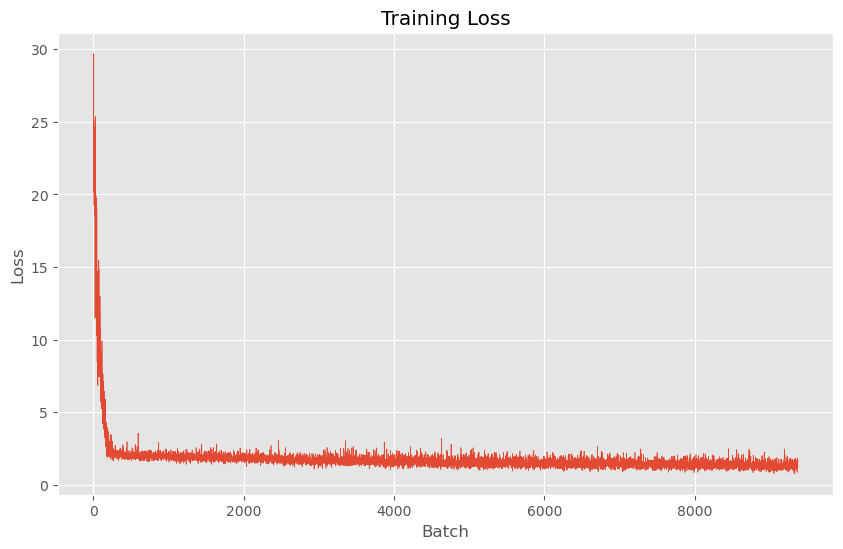

In [6]:
import matplotlib.pyplot as plt

# 设置样式为 'ggplot'
plt.style.use('ggplot')

# 创建一个新的图像，并设置其大小
plt.figure(figsize=(10, 6))

# 绘制损失值，设置线的宽度为 1
plt.plot(losses32[5:], linewidth=0.5)

# 设置图像的标题和坐标轴标签
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')

In [9]:
import numpy as np
np.save('./data/losses16.npy', losses32)


In [10]:
net = Net(hidden_layer_size=16)
sgd = nn.Optimizer(net.parameters(), lr=0.001)
sgd.zero_grad()
losses32 = []
BATCH_SIZE = 32
data = nn.DataLoader([img_train, label_train], shuffle=True, batch_size=BATCH_SIZE)
batch = 0
size = len(img_train)
for epochs in range(5):
    for data_train in data:
        sgd.zero_grad()
        img = data_train[0]
        label = data_train[1]
        output = net(img)
        loss = nn.functional.cross_entropy_loss(output, label) + net.l2normalization()
        loss.backward()
        sgd.step()
        batch += 1
        losses32.append(loss.item())
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{batch * BATCH_SIZE:>5d}/{size:>5d}]")
    with lyu.no_grad():
        output = net(img_test)
        output = np.argmax(output,axis=1)
        label = np.argmax(label_test,axis=1)
        accuracy = accuracy_score(output, label)
        print(f"The accuracy of epoch {epochs + 1} is {100*accuracy}%")


loss: 16.376804  [ 3200/60000]
loss: 10.182649  [ 6400/60000]
loss: 8.642050  [ 9600/60000]
loss: 4.969688  [12800/60000]
loss: 4.383421  [16000/60000]
loss: 4.290708  [19200/60000]
loss: 2.841570  [22400/60000]
loss: 3.781907  [25600/60000]
loss: 4.353862  [28800/60000]
loss: 2.914169  [32000/60000]
loss: 2.617702  [35200/60000]
loss: 2.631261  [38400/60000]
loss: 3.656798  [41600/60000]
loss: 1.992894  [44800/60000]
loss: 2.817708  [48000/60000]
loss: 2.051665  [51200/60000]
loss: 2.488208  [54400/60000]
loss: 2.630471  [57600/60000]
The accuracy of epoch 1 is 23.549999999999997%
loss: 2.109252  [60800/60000]
loss: 2.114769  [64000/60000]
loss: 2.479551  [67200/60000]
loss: 2.470299  [70400/60000]
loss: 2.315234  [73600/60000]
loss: 2.072876  [76800/60000]
loss: 2.247737  [80000/60000]
loss: 2.346216  [83200/60000]
loss: 1.866574  [86400/60000]
loss: 2.325039  [89600/60000]
loss: 2.464750  [92800/60000]
loss: 2.291842  [96000/60000]
loss: 2.894434  [99200/60000]
loss: 2.394769  [1024

In [13]:
np.save('./data/losses16-1e-3lr.npy', losses32)

In [14]:
net = Net(hidden_layer_size=16)
sgd = nn.Optimizer(net.parameters(), lr=0.1)
sgd.zero_grad()
losses32 = []
BATCH_SIZE = 32
data = nn.DataLoader([img_train, label_train], shuffle=True, batch_size=BATCH_SIZE)
batch = 0
size = len(img_train)
for epochs in range(5):
    for data_train in data:
        sgd.zero_grad()
        img = data_train[0]
        label = data_train[1]
        output = net(img)
        loss = nn.functional.cross_entropy_loss(output, label) + net.l2normalization()
        loss.backward()
        sgd.step()
        batch += 1
        losses32.append(loss.item())
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{batch * BATCH_SIZE:>5d}/{size:>5d}]")
    with lyu.no_grad():
        output = net(img_test)
        output = np.argmax(output,axis=1)
        label = np.argmax(label_test,axis=1)
        accuracy = accuracy_score(output, label)
        print(f"The accuracy of epoch {epochs + 1} is {100*accuracy}%")

loss: 2.478213  [ 3200/60000]
loss: 2.392880  [ 6400/60000]
loss: 2.397093  [ 9600/60000]
loss: 2.394427  [12800/60000]
loss: 2.368672  [16000/60000]
loss: 2.379175  [19200/60000]
loss: 2.382947  [22400/60000]
loss: 2.383749  [25600/60000]
loss: 2.388170  [28800/60000]
loss: 2.390741  [32000/60000]
loss: 2.396434  [35200/60000]
loss: 2.385040  [38400/60000]
loss: 2.374258  [41600/60000]
loss: 2.385410  [44800/60000]
loss: 2.375536  [48000/60000]
loss: 2.385396  [51200/60000]
loss: 2.374178  [54400/60000]
loss: 2.393880  [57600/60000]
The accuracy of epoch 1 is 11.35%
loss: 2.371141  [60800/60000]
loss: 2.396411  [64000/60000]
loss: 2.395949  [67200/60000]
loss: 2.369460  [70400/60000]
loss: 2.383850  [73600/60000]
loss: 2.365340  [76800/60000]
loss: 2.370007  [80000/60000]
loss: 2.378524  [83200/60000]
loss: 2.377289  [86400/60000]
loss: 2.371500  [89600/60000]
loss: 2.396918  [92800/60000]
loss: 2.381902  [96000/60000]
loss: 2.376321  [99200/60000]
loss: 2.371859  [102400/60000]
loss:

In [15]:
np.save('./data/losses16-1e-1lr.npy', losses32)

In [17]:
e_1lr = np.load('./data/losses16-1e-1lr.npy')
e_3lr = np.load('./data/losses16-1e-3lr.npy')
e_2lr = np.load('./data/losses16.npy')

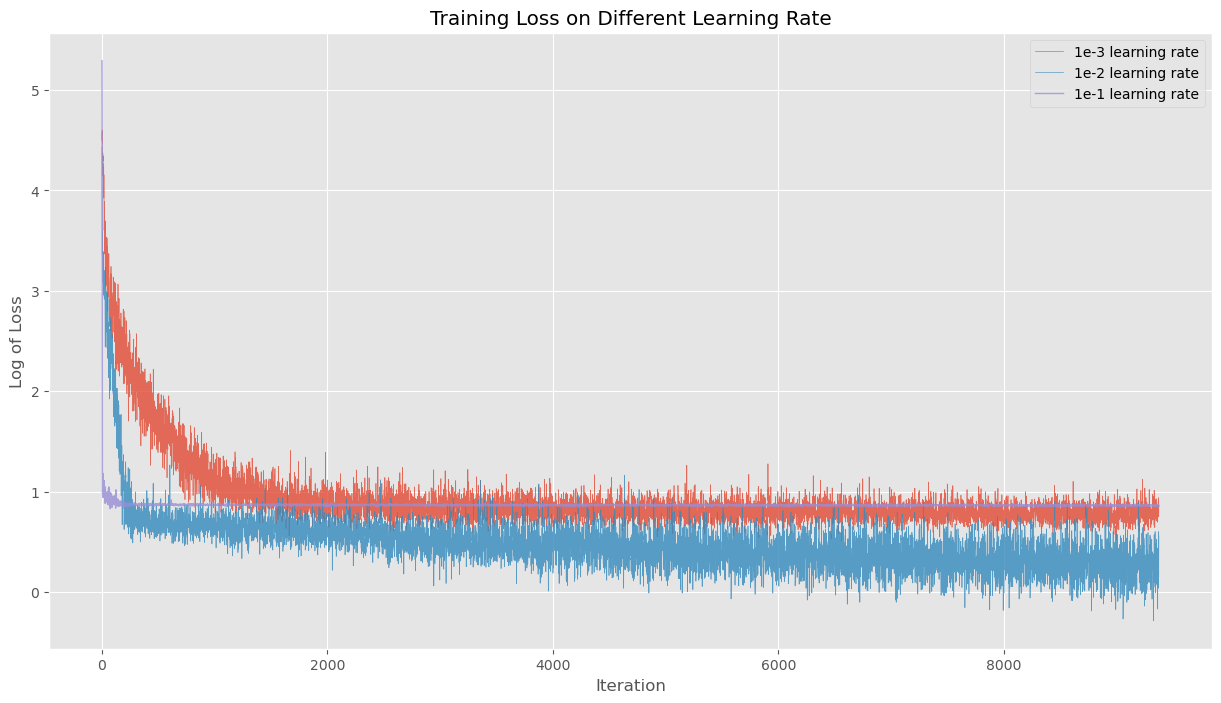

In [49]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 创建一个新的图像，并设置其大小
plt.figure(figsize=(15, 8))

# 绘制损失值，设置线的宽度为 1
plt.plot(np.log(e_3lr),label='1e-3 learning rate', linewidth=0.5,alpha=0.8)
plt.plot(np.log(e_2lr),label='1e-2 learning rate', linewidth=0.5,alpha=0.8)
plt.plot(np.log(e_1lr),label='1e-1 learning rate', linewidth=1,alpha=0.8)
# 设置图像的标题和坐标轴标签
plt.title('Training Loss on Different Learning Rate')
plt.xlabel('Iteration')
plt.ylabel('Log of Loss')
plt.legend()


([<matplotlib.axis.XTick at 0x7f86669340d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

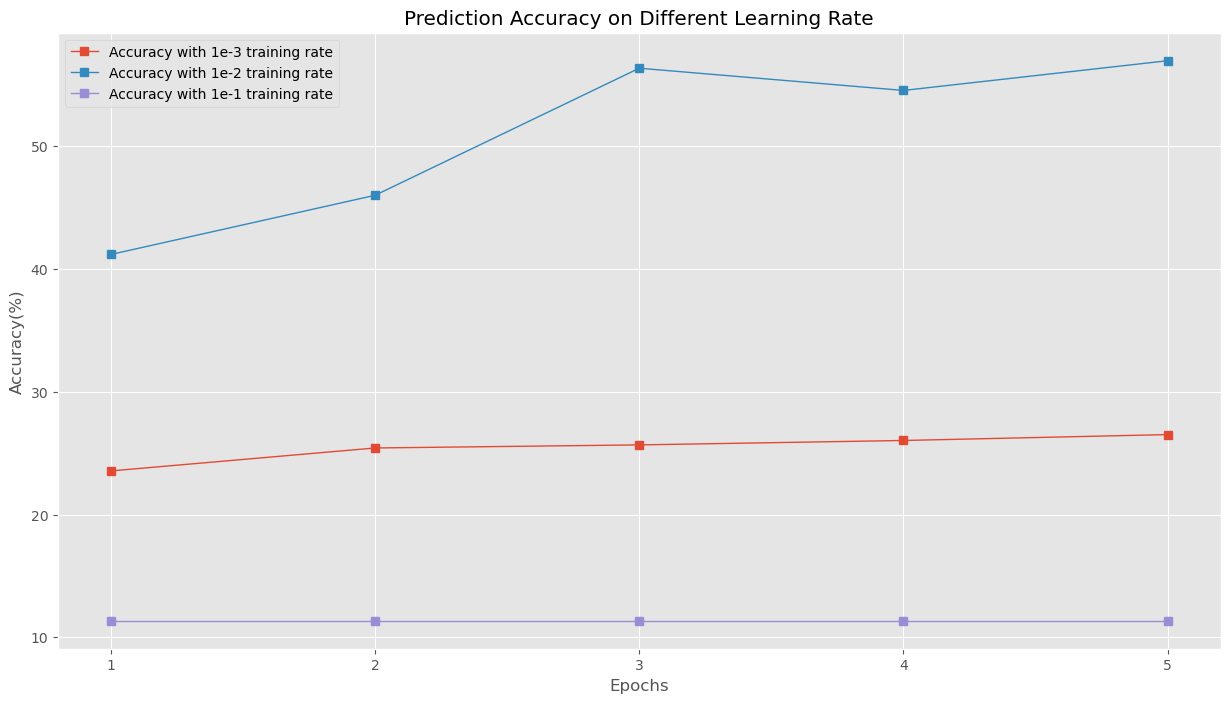

In [77]:
loss_2 = [41.18, 46.0, 56.35, 54.54, 56.96]
loss_1 = [11.35,11.35,11.35,11.35,11.35]
loss_3 = [23.55,25.42, 25.67,26.03,26.51]
plt.figure(figsize=(15, 8))
plt.plot([1,2,3,4,5],loss_3, label='Accuracy with 1e-3 training rate', linewidth=1,marker = 's')
plt.plot([1,2,3,4,5],loss_2, label='Accuracy with 1e-2 training rate', linewidth=1,marker = 's')
plt.plot([1,2,3,4,5],loss_1, label='Accuracy with 1e-1 training rate', linewidth=1,marker = 's')
plt.title('Prediction Accuracy on Different Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.xticks([1,2,3,4,5])